## Set Up Dependencies

In [1]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from teeplot import teeplot as tp


## Fetch and Preprocess Data

In [2]:
df = pd.read_parquet("https://osf.io/wa32b/download")


In [3]:
df = df.rename(
    columns={
        "annotation_size_bits": "Annotation Size (bits)",
        "algorithm": "Algorithm",
        "population_size": "Population Size",
        "num_generations": "Num Generations",
        "num_islands": "Num Islands",
        "num_niches": "Num Niches",
        "tournament_size": "Tournament Size",
        "replicate": "Replicate"
    },
)


In [4]:
df["Dynamics"] = (
    "islands"
    + df["Num Islands"].astype(str)
    + "-niches"
    + df["Num Niches"].astype(str)
    + "-tsize"
    + df["Tournament Size"].astype(str)
)


In [5]:
df["Scenario"] = df["Dynamics"].map(
    {
        "islands1-niches1-tsize2": "plain",
        "islands1-niches1-tsize1": "drift",
        "islands4-niches2-tsize2": "spatial/ecological mild",
        "islands64-niches8-tsize2": "spatial/ecological strong",
    }
)

In [6]:
df["algo"] = df["Algorithm"].map(
    {
        "surf-steady": "surf\nsteady",
        "col-steady": "col\nsteady",
        "surf-hybrid": "surf\nhybrid",
        "surf-tilted": "surf\ntilted",
        "col-tilted": "col\ntilted",
    },
)

In [7]:
df["Scale"] = (
    "npop"
    + df["Population Size"].astype(str)
    + "-ngen"
    + df["Num Generations"].astype(str)
)

In [8]:
row_order=[
    # "surf-steady",
    # "col-steady",
    # "surf-hybrid",
    # "surf-tilted",
    # "col-tilted",
    "surf\nsteady",
    "col\nsteady",
    "surf\nhybrid",
    "surf\ntilted",
    "col\ntilted",
]

def joyhist(*args, **kwargs):
    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

    g = sns.displot(
        *args,
        **kwargs,
        kind="hist",
        row_order=row_order,
        hue_order=["true", "reconstructed"],
        multiple="fill",
        common_norm=False,
        aspect=3,
        height=1,
        log_scale=(True, False),
        bins=20,
        element="step",
        palette=["none", "#1f77b4"],
        facet_kws=dict(margin_titles=True),
        legend=False,
    )
    g.refline(y=0.5, linestyle="--", linewidth=2, color="black")
    g.refline(y=0.0, linestyle="-", linewidth=3, color="black")

    g.figure.subplots_adjust(hspace=-0.4)

    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)
    g.set_titles(col_template="{col_name}", row_template="{row_name}")

    for r, arr in enumerate(g.axes):
        for c, ax in enumerate(arr):
            color = plt.get_cmap('tab10')(r)
            for patch in ax.get_children():
                try:
                    if isinstance(patch, mpl.collections.PolyCollection):
                        patch.set_facecolor(color)
                        patch.set_alpha(0.5)
                        break
                except AttributeError:
                    pass
    return g

/home/runner/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


teeplots/col=scenario+hue=kind+row=algo+viz=joyhist+x=time-ago+ext=.pdf


teeplots/col=scenario+hue=kind+row=algo+viz=joyhist+x=time-ago+ext=.png


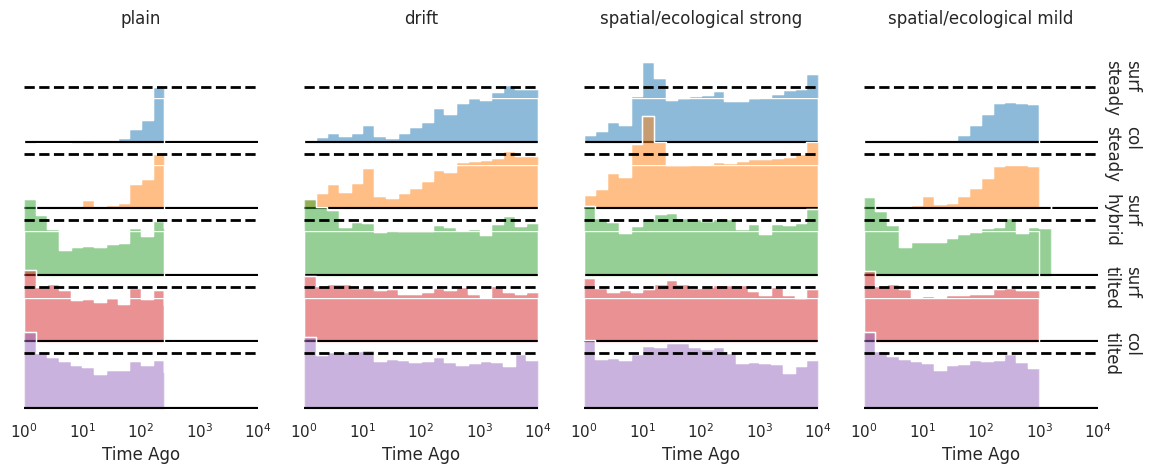

/home/runner/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/runner/.local/lib/python3.10/site-packages/teeplot/teeplot.py:321: UserWarning: teeplot already created file teeplots/col=scenario+hue=kind+row=algo+viz=joyhist+x=time-ago+ext=.pdf, overwriting it
  warnings.warn(


teeplots/col=scenario+hue=kind+row=algo+viz=joyhist+x=time-ago+ext=.pdf


/home/runner/.local/lib/python3.10/site-packages/teeplot/teeplot.py:321: UserWarning: teeplot already created file teeplots/col=scenario+hue=kind+row=algo+viz=joyhist+x=time-ago+ext=.png, overwriting it
  warnings.warn(


teeplots/col=scenario+hue=kind+row=algo+viz=joyhist+x=time-ago+ext=.png


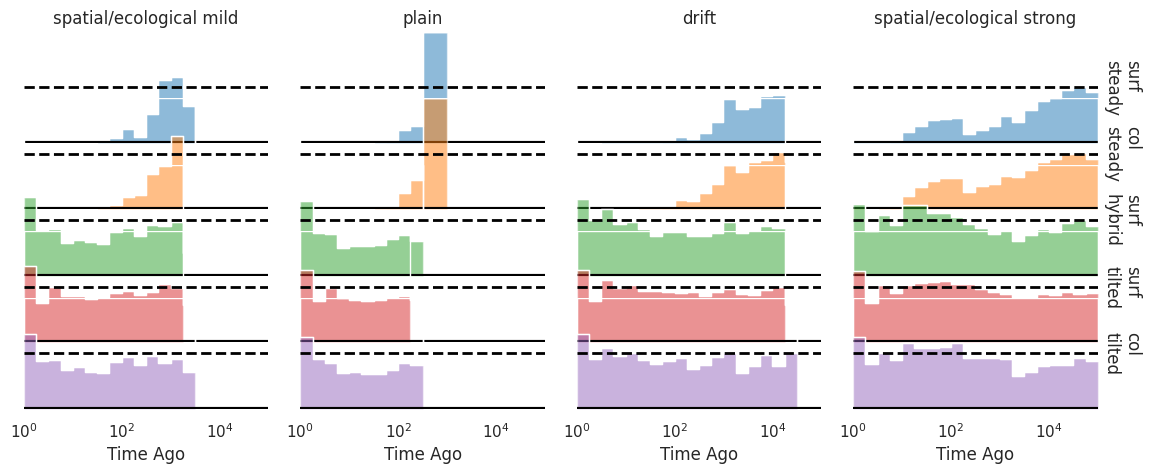

/home/runner/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/runner/.local/lib/python3.10/site-packages/teeplot/teeplot.py:321: UserWarning: teeplot already created file teeplots/col=scenario+hue=kind+row=algo+viz=joyhist+x=time-ago+ext=.pdf, overwriting it
  warnings.warn(


teeplots/col=scenario+hue=kind+row=algo+viz=joyhist+x=time-ago+ext=.pdf


/home/runner/.local/lib/python3.10/site-packages/teeplot/teeplot.py:321: UserWarning: teeplot already created file teeplots/col=scenario+hue=kind+row=algo+viz=joyhist+x=time-ago+ext=.png, overwriting it
  warnings.warn(


teeplots/col=scenario+hue=kind+row=algo+viz=joyhist+x=time-ago+ext=.png


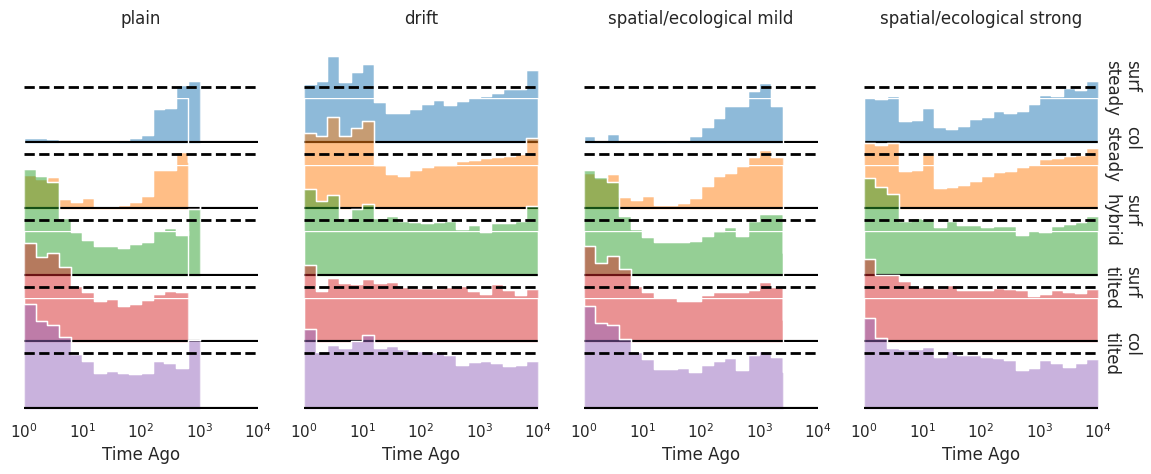

/home/runner/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/runner/.local/lib/python3.10/site-packages/teeplot/teeplot.py:321: UserWarning: teeplot already created file teeplots/col=scenario+hue=kind+row=algo+viz=joyhist+x=time-ago+ext=.pdf, overwriting it
  warnings.warn(


teeplots/col=scenario+hue=kind+row=algo+viz=joyhist+x=time-ago+ext=.pdf


/home/runner/.local/lib/python3.10/site-packages/teeplot/teeplot.py:321: UserWarning: teeplot already created file teeplots/col=scenario+hue=kind+row=algo+viz=joyhist+x=time-ago+ext=.png, overwriting it
  warnings.warn(


teeplots/col=scenario+hue=kind+row=algo+viz=joyhist+x=time-ago+ext=.png


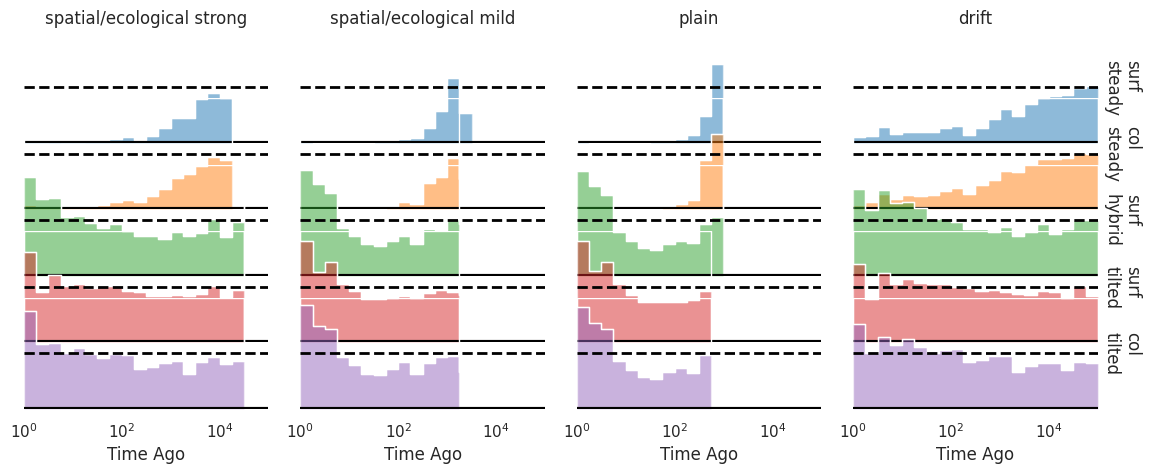

In [9]:
for __, group in df.groupby("Scale"):
    group["Time Ago"] = group["origin_time"].max() + 1 - group["origin_time"]
    tp.tee(
        joyhist,
        data=group,
        x="Time Ago",
        row="algo",
        col="Scenario",
        hue="kind",
    )

## Reproducibility

In [10]:
import datetime
datetime.datetime.now().isoformat()

'2024-04-01T18:13:13.382019'

In [11]:
%load_ext watermark
%watermark

Last updated: 2024-04-01T18:13:13.394987+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.22.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.5.0-1016-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit



In [12]:
!pip freeze

alifedata-phyloinformatics-convert==0.16.2
annotated-types==0.6.0
anytree==2.12.1
appdirs==1.4.4
argcomplete==3.2.3
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
asttokens==2.4.1
attrs==23.2.0
Automat==20.2.0
Babel==2.8.0
backstrip==0.2.4
bcrypt==3.2.0
beautifulsoup4==4.12.3
biopython==1.83
bitarray==2.9.2
bitstring==4.1.4
black==22.10.0
bleach==6.1.0
blinker==1.4
Brotli==1.1.0
CacheControl==0.12.10
certifi==2024.2.2
cffi==1.16.0
chardet==4.0.0
charset-normalizer==3.3.2
click==8.1.7
cliffs-delta==1.0.0
cloud-init==23.4.4
colorama==0.4.4
comm==0.2.1
command-not-found==0.3
configobj==5.0.6
constantly==15.1.0
contourpy==1.2.0
cryptography==3.4.8
cssselect==1.1.0
cssselect2==0.7.0
cycler==0.12.1
dataclasses==0.6
dbus-python==1.2.18
debugpy==1.8.1
decorator==5.1.1
defusedxml==0.7.1
DendroPy==4.6.1
Deprecated==1.2.14
distro==1.7.0
distro-info==1.1+ubuntu0.2
distutils-strtobool==0.1.0
entrypoints==0.4
ete3==3.1.3
exceptiongroup==1.2.0
executing==2.0.1
fastjsonschema==2.19.1
fonttools==4.49